# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [4]:
# imports
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix


In [2]:


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
model.fit(X_train, y_train)

LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

In [5]:
model.score(X_test, y_test)

0.769682876344773

In [45]:
scaler = MinMaxScaler()
X_train[["AGEP"]] = scaler.fit_transform(X_train[["AGEP"]])
X_test[["AGEP"]] = scaler.fit_transform(X_test[["AGEP"]])

In [47]:
model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
model.fit(X_train, y_train)

LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

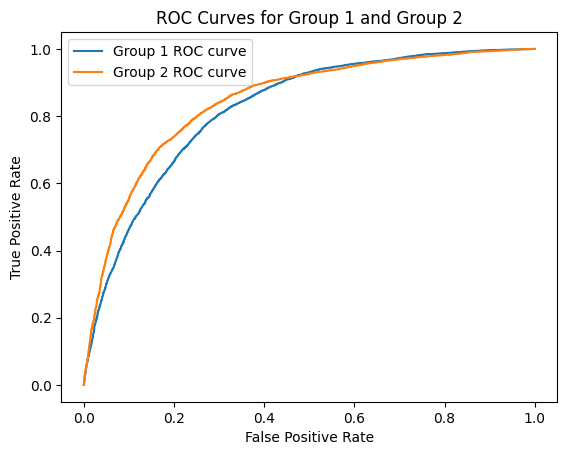

In [17]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

group1 = X_test["SEX_2"] == True
group2 = X_test["SEX_2"] == False

predictions = model.predict_proba(X_test
)
# Calculate the ROC curve for group1
fpr_group1, tpr_group1, thresholds_group1 = metrics.roc_curve(y_test[group1], predictions[group1, 1])

# Calculate the ROC curve for group2
fpr_group2, tpr_group2, thresholds_group2 = metrics.roc_curve(y_test[group2], predictions[group2, 1])

# Plot ROC curve for group1
plt.plot(fpr_group1, tpr_group1, label='Group 1 ROC curve')
# Plot ROC curve for group2
plt.plot(fpr_group2, tpr_group2, label='Group 2 ROC curve')
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Group 1 and Group 2')
# Add legend
plt.legend()
# Show the plot
plt.show()



358945     True
275788     True
141517     True
66729     False
268579     True
          ...  
296811     True
343651     True
231468    False
337479    False
89988      True
Name: SEX_2, Length: 156532, dtype: bool

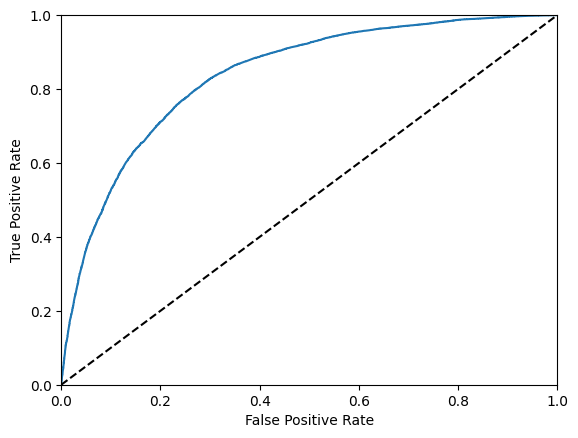

In [54]:
import sklearn.metrics as metrics
predictions = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions[:,1])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [49]:
cm = confusion_matrix(y_test, model.predict(X_test))
cm


array([[12397,  5091],
       [ 3923, 17722]], dtype=int64)

In [50]:
model.score(X_test, y_test)
# Retrieve the coefficients of the logistic regression model
coefficients = model.coef_[0]
# Compute the odds ratio
odds_ratio = np.exp(coefficients)

std_error = np.std(X_train, axis=0) * coefficients
coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients, 'Odds Ratio': odds_ratio, 'Std Error': std_error})
# Sort the dataframe by coefficient values in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the dataframe
coefficients_df

,Feature,Coefficient,Odds Ratio,Std Error
AGEP,AGEP,2.874677,17.719707,0.555927
SCHL_24.0,SCHL_24.0,2.455727,11.654905,0.342636
SCHL_23.0,SCHL_23.0,2.427629,11.331983,0.404600
SCHL_22.0,SCHL_22.0,2.239914,9.392528,0.672904
SCHL_21.0,SCHL_21.0,1.739757,5.695962,0.740874
SCHL_20.0,SCHL_20.0,0.991985,2.696583,0.269799
HINS4_2,HINS4_2,0.835348,2.305615,0.292438
SCHL_19.0,SCHL_19.0,0.705580,2.025022,0.261536
SCHL_18.0,SCHL_18.0,0.657618,1.930189,0.164072
SCHL_17.0,SCHL_17.0,0.615826,1.851185,0.088678


In [ ]:
fpr, tpr, thresholds = roc_curve